In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.task_switching.hooks as hooks
from multitask.models.task_switching.models import get_task_model
from multitask.representations import get_mean_activations, calculate_rdm, plot_rdm, calculate_rsa_diagonal
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ['#c0d9ffff', '#bfc1ffff', '#e3bfffff', '#ffbfe6ff', '#ffbfc4ff']

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure_rdm_first = os.path.join('svg', 'figure03a_rdm_first.svg')
path_figure_rdm_all = os.path.join('svg', 'figure03a_rdm_all.svg')
path_figure_rdm_last = os.path.join('svg', 'figure03a_rdm_removed.svg')
path_figure_rsa = os.path.join('svg', 'figure03a_rsa_contexts.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

## Contexts  First

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = [0]

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-27_22_43_11)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


In [9]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing  = sorted(list(results_task_switching.keys()))
list_rdm_task_switching_first = []

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)
    
    list_rdm_task_switching_first.append(rdm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

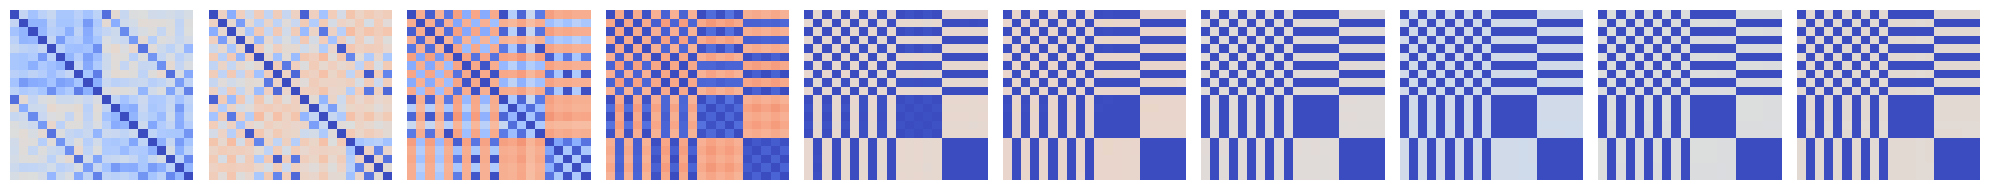

In [10]:
mean_rdm_first = {}
num_layers = len(num_hidden)

for layer in range(num_layers):
    mean_rdm_first[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_rdm_task_switching_first:
        mean_rdm_first[layer+1] += rdm[layer+1]
    mean_rdm_first[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm_first, num_hidden, cmap='coolwarm', vmin=0, vmax=2)
fig.tight_layout()
# fig.savefig(path_figure_rdm_first)
plt.show()

## Contexts All

In [11]:
idxs_contexts = list(range(len(num_hidden)))
parameters['idxs_contexts'] = idxs_contexts

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_02_23_14)


In [12]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [13]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [14]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing = sorted(list(results_task_switching.keys()))
list_rdm_task_switching_all = []

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)
    
    list_rdm_task_switching_all.append(rdm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

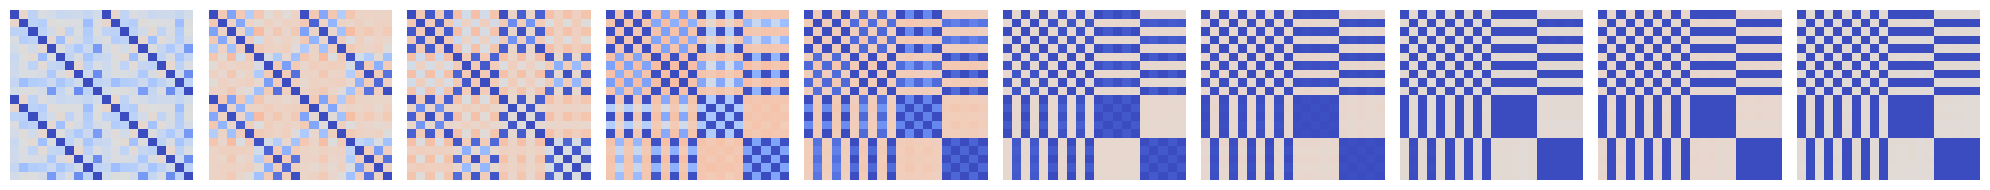

In [15]:
mean_rdm_all = {}
num_layers = len(num_hidden)

for layer in range(num_layers):
    mean_rdm_all[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_rdm_task_switching_all:
        mean_rdm_all[layer+1] += rdm[layer+1]
    mean_rdm_all[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm_all, num_hidden, cmap='coolwarm', vmin=0, vmax=2)
fig.tight_layout()

# fig.savefig(path_figure_rdm_all)

plt.show()

## Context Last

In [16]:
idxs_contexts = [9]
parameters['idxs_contexts'] = idxs_contexts

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-27_22_43_20)


In [17]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [18]:
device = get_device()
criterion = nn.CrossEntropyLoss()

seeds_task_swithing = sorted(list(results_task_switching.keys()))
list_rdm_task_switching_last = []

for i_seed, seed in tqdm(enumerate(seeds_task_swithing), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)

    list_rdm_task_switching_last.append(rdm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

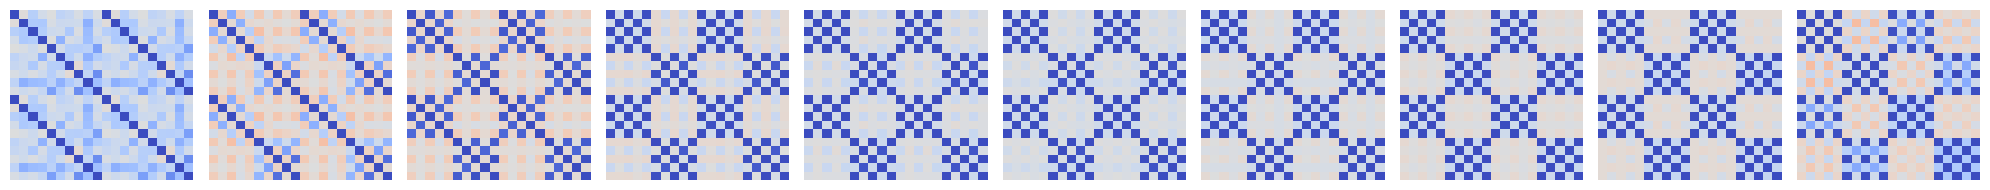

In [19]:
mean_rdm_last = {}
num_layers = len(num_hidden)

for layer in range(num_layers):
    mean_rdm_last[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_rdm_task_switching_last:
        mean_rdm_last[layer+1] += rdm[layer+1]
    mean_rdm_last[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm_last, num_hidden, cmap='coolwarm', vmin=0, vmax=2)
fig.tight_layout()

# fig.savefig(path_figure_rdm_last)

plt.show()

## RSA

In [20]:
rsa_first_all = calculate_rsa_diagonal(list_rdm_task_switching_first,
                                       list_rdm_task_switching_all,
                                       num_inputs=10)

mean_first_all = rsa_first_all.mean(axis=0)
std_first_all = rsa_first_all.std(axis=0)

rsa_last_all = calculate_rsa_diagonal(list_rdm_task_switching_last,
                                      list_rdm_task_switching_all,
                                       num_inputs=10)

mean_last_all = rsa_last_all.mean(axis=0)
std_last_all = rsa_last_all.std(axis=0)

In [21]:
median_first_all = np.median(rsa_first_all, axis=0)
percentile_25_first_all = np.percentile(rsa_first_all, 25, axis=0)
percentile_75_first_all = np.percentile(rsa_first_all, 75, axis=0)

median_last_all = np.median(rsa_last_all, axis=0)
percentile_25_last_all = np.percentile(rsa_last_all, 25, axis=0)
percentile_75_last_all = np.percentile(rsa_last_all, 75, axis=0)

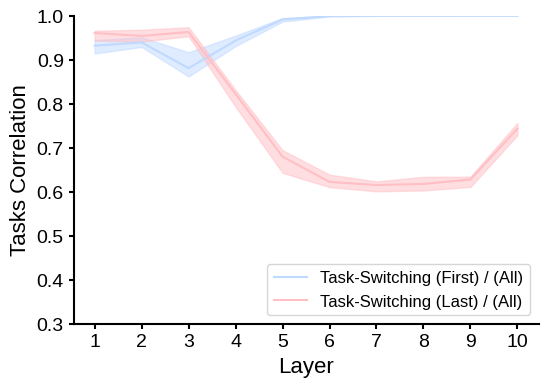

In [22]:
layers = range(1, num_layers + 1)
fig = plt.figure(figsize=(6, 4))

plt.plot(layers, median_first_all, color=palette[0])
plt.plot(layers, median_last_all, color=palette[-1])

plt.fill_between(layers,
                 percentile_25_first_all,
                 percentile_75_first_all,
                 alpha=0.5,
                 color=palette[0])

plt.fill_between(layers,
                 percentile_25_last_all,
                 percentile_75_last_all,
                 alpha=0.5,
                 color=palette[-1])

plt.xlabel('Layer')
plt.xticks(range(1, num_layers+1))
plt.legend(['Task-Switching (First) / (All)', 'Task-Switching (Last) / (All)'], loc='lower right', prop={'size':12})
plt.ylabel('Tasks Correlation')
plt.ylim(0.3, 1)
fig.savefig(path_figure_rsa)

plt.show()